In [16]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import missingno as msno
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
pd.set_option('display.max_columns', None)

In [17]:
def load_data(path):
    df = pd.read_csv(path, parse_dates=['datetime'])
    df = df.sort_index()
    columns_to_drop = ['Unnamed: 0', 'sunrise', 'sunset']
    df = df.drop(columns=columns_to_drop)
    df['datetime'] = pd.to_datetime(df['datetime'])

    last_year = df['datetime'].max() - pd.DateOffset(years=1)
    df_last_year = df[df['datetime'] >= last_year]
    df = df.sort_values('datetime')
    
    return df, df_last_year


In [18]:
df_london, df_last_year_london = load_data(r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\london_weather_2014-2024.csv')
df_manila, df_last_year_manila = load_data(r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\manila_weather_2014-2024.csv')


In [19]:
df_london

name   datetime  tempmax  tempmin  temp  \
0     London, England, United Kingdom 2014-01-01     11.6      6.7   9.1   
1     London, England, United Kingdom 2014-01-02     11.0      6.6   9.1   
2     London, England, United Kingdom 2014-01-03     10.6      7.3   9.0   
3     London, England, United Kingdom 2014-01-04     10.1      4.5   8.0   
4     London, England, United Kingdom 2014-01-05     12.0      1.8   6.0   
...                               ...        ...      ...      ...   ...   
3788  London, England, United Kingdom 2024-05-16     16.5     12.3  14.2   
3789  London, England, United Kingdom 2024-05-17     21.6     10.0  16.4   
3790  London, England, United Kingdom 2024-05-18     19.2     13.0  15.8   
3791  London, England, United Kingdom 2024-05-19     22.7     10.9  16.6   
3792  London, England, United Kingdom 2024-05-20     20.2     10.0  15.1   

      feelslikemax  feelslikemin  feelslike   dew  humidity  precip  \
0             11.6           3.6        7.0   6.7      84.8  11.857   
1             11.0           3.6        7.2   6.0      81.0   5.394   
2             10.6           3.2        6.5   5.1      76.8   6.030   
3             10.1           2.0        5.1   5.2      82.4   5.239   
4             12.0          -0.9        3.6   3.9      85.9   0.201   
...            ...           ...        ...   ...       ...     ...   
3788          16.5          12.3       14.2  12.4      89.1  10.126   
3789          21.6          10.0       16.4  10.3      70.2   0.000   
3790          19.2          13.0       15.8  11.7      77.5   2.000   
3791          22.7          10.9       16.6   9.3      63.9   0.000   
3792          20.2           8.5       14.9   9.2      69.8   0.100   

      precipprob  precipcover preciptype  snow  snowdepth  windgust  \
0            100        16.67       rain   0.0        0.0      72.4   
1            100        12.50       rain   0.0        0.0      51.8   
2            100        16.67       rain   0.0        0.0      77.4   
3            100        16.67       rain   0.0        0.0      62.1   
4            100         8.33       rain   0.0        0.0      55.6   
...          ...          ...        ...   ...        ...       ...   
3788         100        20.83       rain   0.0        0.0      18.4   
3789           0         0.00       rain   0.0        0.0      17.4   
3790         100        25.00       rain   0.0        0.0      22.7   
3791           0         0.00        NaN   0.0        0.0      34.2   
3792         100         4.17       rain   0.0        0.0      32.0   

      windspeed  winddir  sealevelpressure  cloudcover  visibility  \
0          38.4    190.5             993.1        67.4        14.2   
1          29.8    216.2             993.4        47.4        26.7   
2          33.5    218.4             994.5        52.8        17.9   
3          29.2    206.0             993.6        67.6        22.0   
4          30.4    192.5            1000.0        66.5        25.5   
...         ...      ...               ...         ...         ...   
3788       10.1    213.9            1005.2        58.3        15.8   
3789        9.4    194.8            1009.3        41.4        21.7   
3790       13.4      5.8            1012.8        83.7         9.7   
3791       20.3     38.3            1013.8        53.5        10.0   
3792       19.5     43.4            1013.6        36.8        10.0   

      solarradiation  solarenergy  uvindex  severerisk  moonphase  \
0                6.9          0.5        0         NaN       0.00   
1               38.3          3.3        2         NaN       0.03   
2               30.3          2.8        2         NaN       0.07   
3               17.4          1.4        1         NaN       0.10   
4               30.4          2.6        2         NaN       0.14   
...              ...          ...      ...         ...        ...   
3788            74.5          6.5        3        10.0       0.27   
3789           177.8 

## Testing for stationarity of the data

In [20]:
def test_stationarity(df):
    result = adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print('TS is stationary')
    else:
        print('TS not stationary')

    
    

In [21]:
test_stationarity(df_manila['temp'])

ADF Statistic: -6.139003242410702
p-value: 8.0561165344187e-08
TS is stationary


## Descriptive statistics and EDA

In [22]:
def descriptive_stats(df):
    print("shape: ", df.shape)
    print("column headers: ", df.columns)
    print("first date in series: ", df_london['datetime'].min())
    print("last date in series: ", df_london['datetime'].max())
    print("minimum temperature: ", df_london['temp'].min())
    print("maximum temperature: ", df_london['temp'].max())
    print("missing data: ", df_london.isna().sum())
    print("descriptive statistics: ", df_london.describe())
    print("df info: ", df_london.info())
    print("number of missing values per column: ", df_london.isnull().sum())
    

In [23]:
descriptive_stats(df_london)

shape:  (3793, 31)
column headers:  Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase',
       'conditions', 'description', 'icon', 'stations'],
      dtype='object')
first date in series:  2014-01-01 00:00:00
last date in series:  2024-05-20 00:00:00
minimum temperature:  -3.2
maximum temperature:  30.3
missing data:  name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
sno

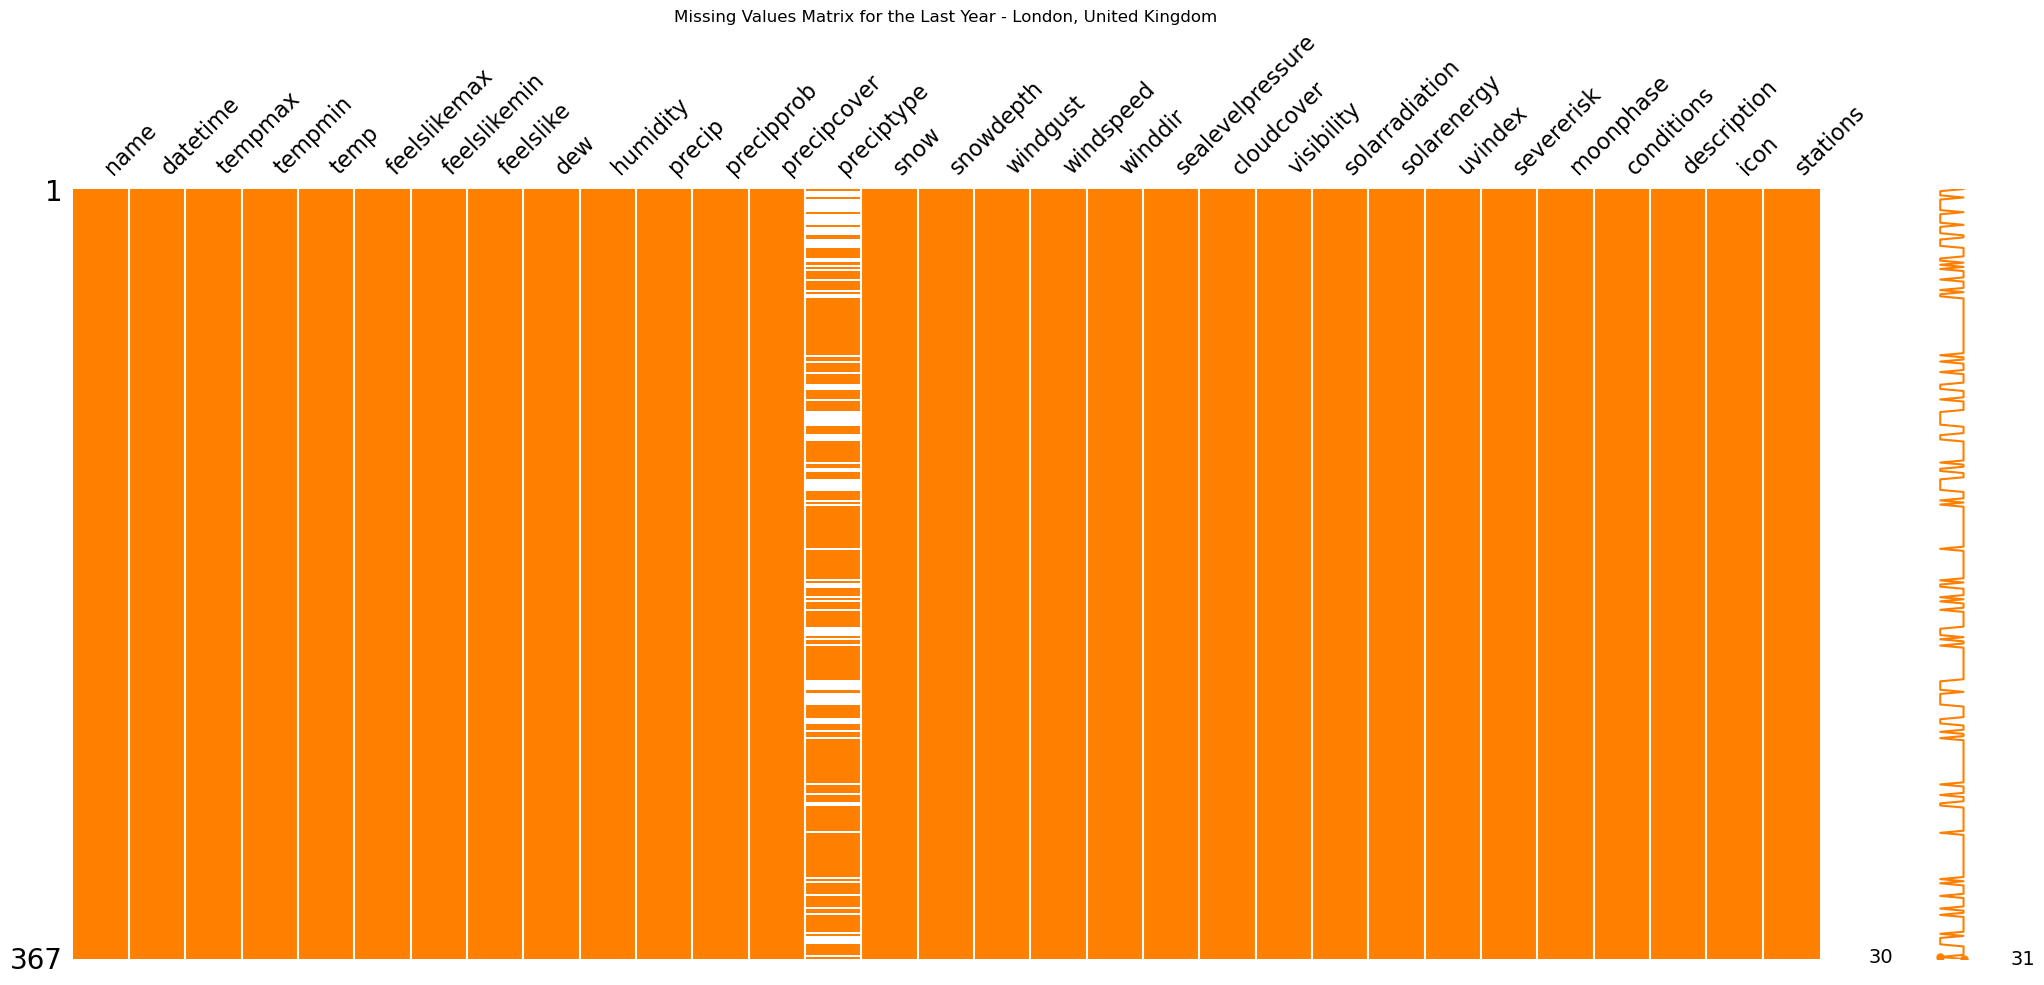

In [24]:


msno.matrix(df_last_year_london, color=(1.0, 0.5, 0.0))
plt.title('Missing Values Matrix for the Last Year - London, United Kingdom')
plt.show()

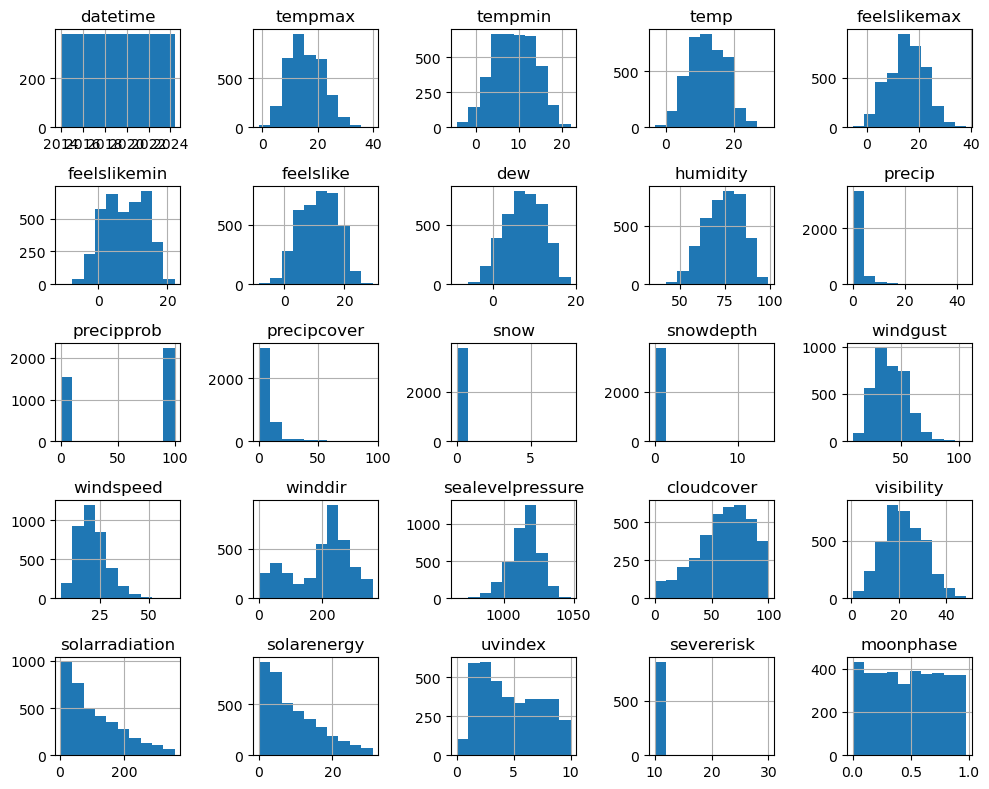

In [25]:
df_london.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

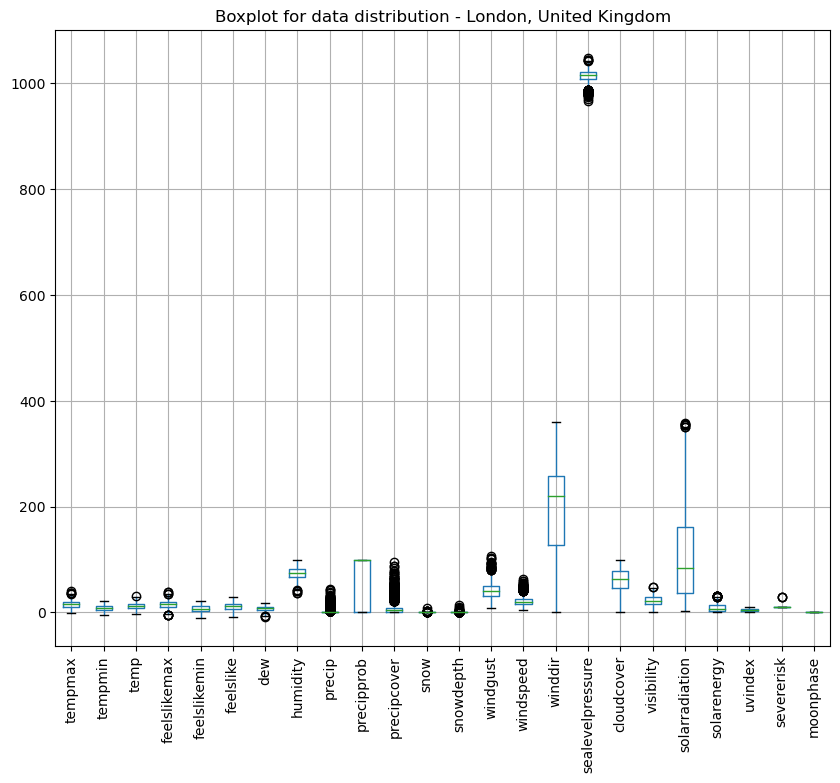

In [26]:
df_london.boxplot(figsize=(10, 8))
plt.xticks(rotation=90)
plt.title('Boxplot for data distribution - London, United Kingdom')
plt.show()

In [27]:
df_london_for_corr = df_london.drop(['name', 'preciptype', 'conditions','description','icon', 'stations'],axis=1)

In [28]:
df_london_for_corr.head()

datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0 2014-01-01     11.6      6.7   9.1          11.6           3.6        7.0   
1 2014-01-02     11.0      6.6   9.1          11.0           3.6        7.2   
2 2014-01-03     10.6      7.3   9.0          10.6           3.2        6.5   
3 2014-01-04     10.1      4.5   8.0          10.1           2.0        5.1   
4 2014-01-05     12.0      1.8   6.0          12.0          -0.9        3.6   

   dew  humidity  precip  precipprob  precipcover  snow  snowdepth  windgust  \
0  6.7      84.8  11.857         100        16.67   0.0        0.0      72.4   
1  6.0      81.0   5.394         100        12.50   0.0        0.0      51.8   
2  5.1      76.8   6.030         100        16.67   0.0        0.0      77.4   
3  5.2      82.4   5.239         100        16.67   0.0        0.0      62.1   
4  3.9      85.9   0.201         100         8.33   0.0        0.0      55.6   

   windspeed  winddir  sealevelpressure  cloudcover  visibility  \
0       38.4    190.5             993.1        67.4        14.2   
1       29.8    216.2             993.4        47.4        26.7   
2       33.5    218.4             994.5        52.8        17.9   
3       29.2    206.0             993.6        67.6        22.0   
4       30.4    192.5            1000.0        66.5        25.5   

   solarradiation  solarenergy  uvindex  severerisk  moonphase  
0             6.9          0.5        0         NaN       0.00  
1            38.3          3.3        2         NaN       0.03  
2            30.3          2.8        2         NaN       0.07  
3            17.4          1.4        1         NaN       0.10  
4            30.4          2.6        2         NaN       0.14

In [29]:
corr_matrix = df_london_for_corr.corr()
print(corr_matrix) 

                  datetime   tempmax   tempmin      temp  feelslikemax  \
datetime          1.000000  0.008865  0.010205  0.007740      0.012812   
tempmax           0.008865  1.000000  0.880739  0.973772      0.992570   
tempmin           0.010205  0.880739  1.000000  0.956810      0.882454   
temp              0.007740  0.973772  0.956810  1.000000      0.970469   
feelslikemax      0.012812  0.992570  0.882454  0.970469      1.000000   
feelslikemin      0.010829  0.892497  0.984158  0.957931      0.897502   
feelslike         0.011530  0.966945  0.950490  0.992946      0.972603   
dew               0.025422  0.815229  0.919002  0.888771      0.826023   
humidity          0.047910 -0.510786 -0.295188 -0.433604     -0.484854   
precip            0.019130 -0.079772  0.028707 -0.037742     -0.072548   
precipprob       -0.058845 -0.235622 -0.062457 -0.167136     -0.222448   
precipcover       0.236525 -0.163003 -0.025887 -0.107080     -0.148046   
snow              0.007829 -0.115714 -

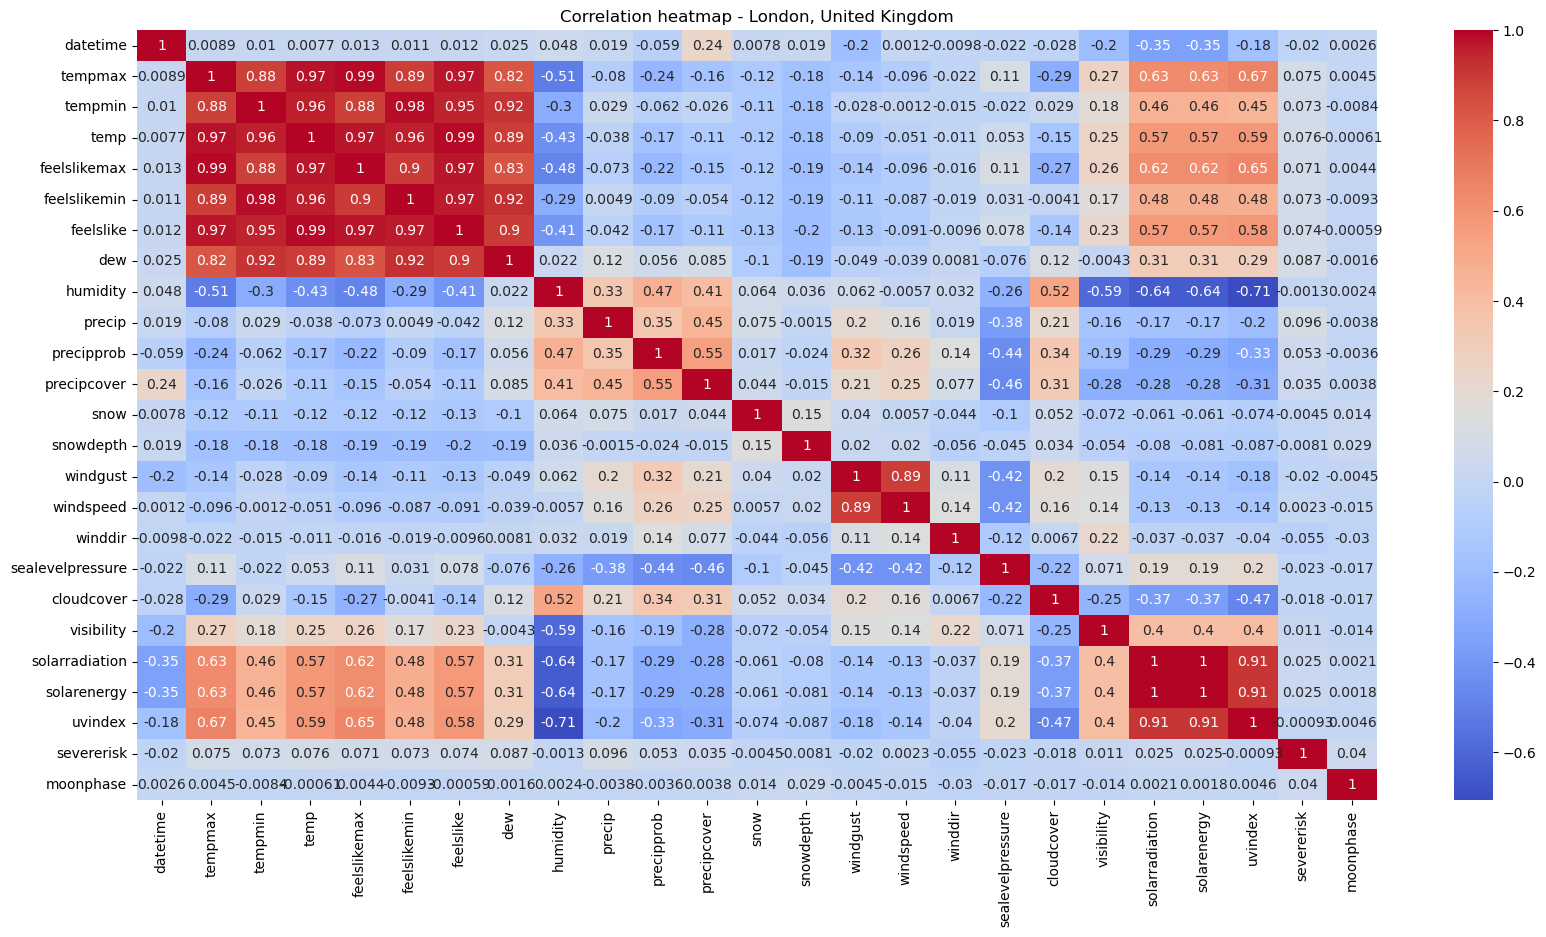

In [30]:
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation heatmap - London, United Kingdom")
plt.show()

look into the correlation that humidity has with temp (-0.43) + solarradiation, solarenergy or uvindex
look into multicolinearity - multiple feature that are roughly the same as the target, which need to be removed (first 5 after the first one)

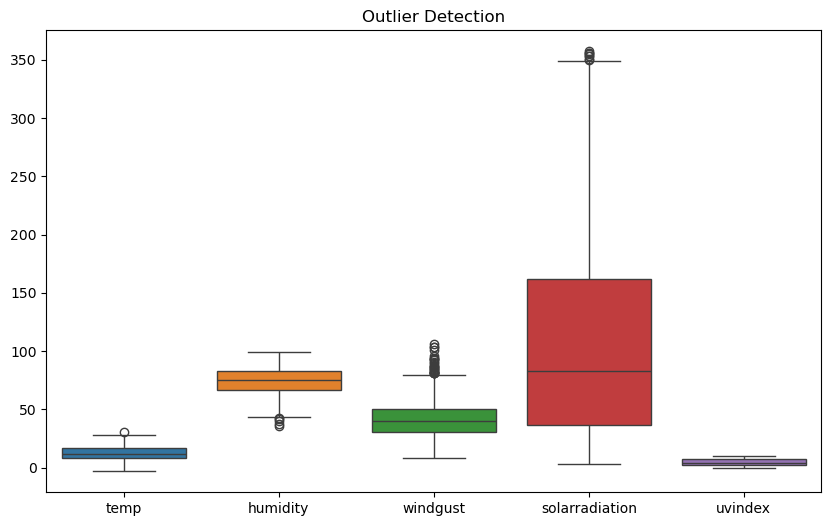

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_london[['temp', 'humidity', 'windgust', 'solarradiation', 'uvindex']])
plt.title("Outlier Detection")
plt.show()

In [32]:
# look into how each of these are measured 
# for example temp is the average at 18 
#first run the models with outliers and then see the results 

In [33]:
df_london.set_index("datetime", inplace = True)
df_london.sort_index(inplace = True)

In [34]:
df_london

name  tempmax  tempmin  temp  \
datetime                                                              
2014-01-01  London, England, United Kingdom     11.6      6.7   9.1   
2014-01-02  London, England, United Kingdom     11.0      6.6   9.1   
2014-01-03  London, England, United Kingdom     10.6      7.3   9.0   
2014-01-04  London, England, United Kingdom     10.1      4.5   8.0   
2014-01-05  London, England, United Kingdom     12.0      1.8   6.0   
...                                     ...      ...      ...   ...   
2024-05-16  London, England, United Kingdom     16.5     12.3  14.2   
2024-05-17  London, England, United Kingdom     21.6     10.0  16.4   
2024-05-18  London, England, United Kingdom     19.2     13.0  15.8   
2024-05-19  London, England, United Kingdom     22.7     10.9  16.6   
2024-05-20  London, England, United Kingdom     20.2     10.0  15.1   

            feelslikemax  feelslikemin  feelslike   dew  humidity  precip  \
datetime                                                                    
2014-01-01          11.6           3.6        7.0   6.7      84.8  11.857   
2014-01-02          11.0           3.6        7.2   6.0      81.0   5.394   
2014-01-03          10.6           3.2        6.5   5.1      76.8   6.030   
2014-01-04          10.1           2.0        5.1   5.2      82.4   5.239   
2014-01-05          12.0          -0.9        3.6   3.9      85.9   0.201   
...                  ...           ...        ...   ...       ...     ...   
2024-05-16          16.5          12.3       14.2  12.4      89.1  10.126   
2024-05-17          21.6          10.0       16.4  10.3      70.2   0.000   
2024-05-18          19.2          13.0       15.8  11.7      77.5   2.000   
2024-05-19          22.7          10.9       16.6   9.3      63.9   0.000   
2024-05-20          20.2           8.5       14.9   9.2      69.8   0.100   

            precipprob  precipcover preciptype  snow  snowdepth  windgust  \
datetime                                                                    
2014-01-01         100        16.67       rain   0.0        0.0      72.4   
2014-01-02         100        12.50       rain   0.0        0.0      51.8   
2014-01-03         100        16.67       rain   0.0        0.0      77.4   
2014-01-04         100        16.67       rain   0.0        0.0      62.1   
2014-01-05         100         8.33       rain   0.0        0.0      55.6   
...                ...          ...        ...   ...        ...       ...   
2024-05-16         100        20.83       rain   0.0        0.0      18.4   
2024-05-17           0         0.00       rain   0.0        0.0      17.4   
2024-05-18         100        25.00       rain   0.0        0.0      22.7   
2024-05-19           0         0.00        NaN   0.0        0.0      34.2   
2024-05-20         100         4.17       rain   0.0        0.0      32.0   

            windspeed  winddir  sealevelpressure  cloudcover  visibility  \
datetime                                                                   
2014-01-01       38.4    190.5             993.1        67.4        14.2   
2014-01-02       29.8    216.2             993.4        47.4        26.7   
2014-01-03       33.5    218.4             994.5        52.8        17.9   
2014-01-04       29.2    206.0             993.6        67.6        22.0   
2014-01-05       30.4    192.5            1000.0        66.5        25.5   
...               ...      ...               ...         ...         ...   
2024-05-16       10.1    213.9            1005.2        58.3        15.8   
2024-05-17        9.4    194.8            1009.3        41.4        21.7   
2024-05-18       13.4      5.8            1012.8        83.7         9.7   
2024-05-19       20.3     38.3            1013.8        53.5        10.0   
2024-05-20       19.5     43.4            1013.6        36.8        10.0   

            solarradiation  solarenergy  uvindex  severerisk  moonphase  \
datetime                                       

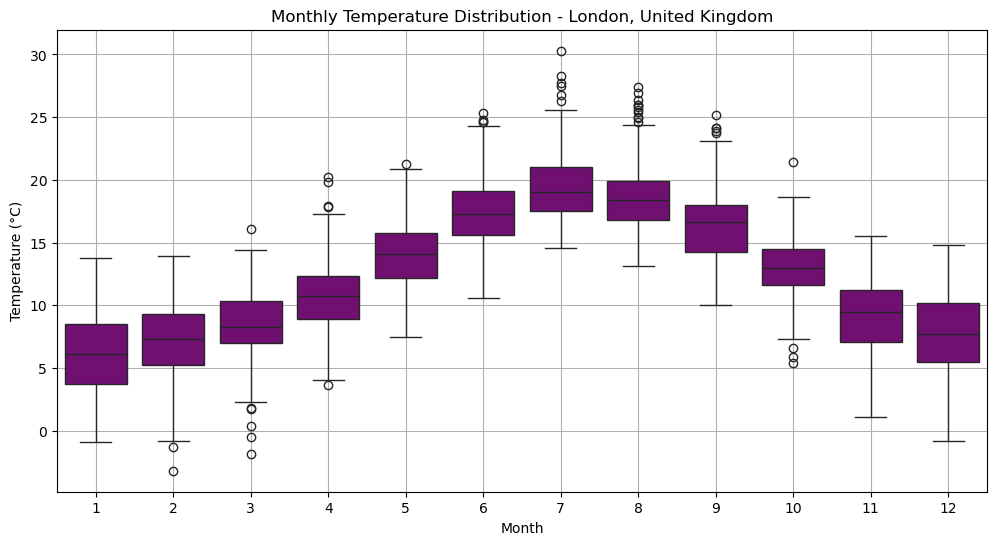

In [35]:
df_london['month'] = df_london.index.month

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp', data=df_london, color="purple")
plt.title('Monthly Temperature Distribution - London, United Kingdom')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

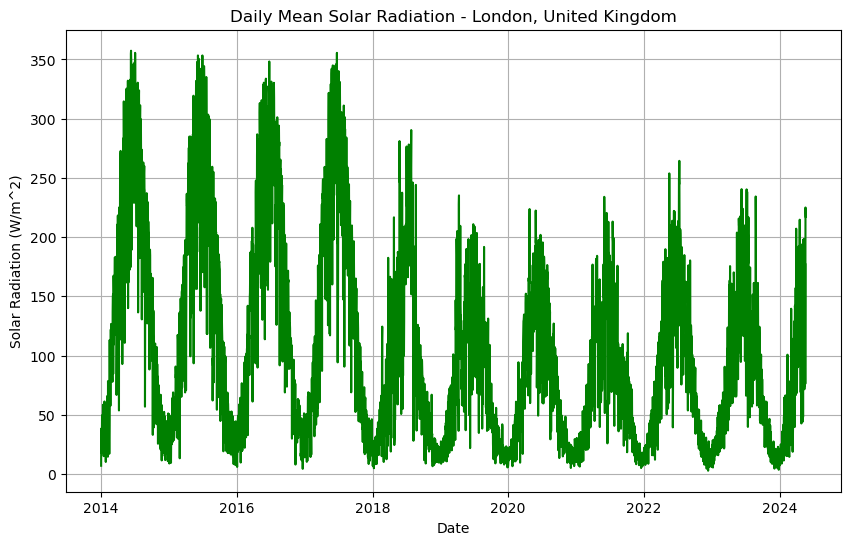

In [36]:
daily_solar_radiation = df_london['solarradiation'].resample('D').mean()

plt.figure(figsize=(10, 6))
plt.plot(daily_solar_radiation.index, daily_solar_radiation.values, linestyle='-', color='green')
plt.title('Daily Mean Solar Radiation - London, United Kingdom')
plt.xlabel('Date')
plt.ylabel('Solar Radiation (W/m^2)')
plt.grid(True)
plt.show()

## Missing values

In [37]:
df_london.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
snow                   0
snowdepth              0
windgust             175
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          2931
moonphase              0
conditions             0
description            0
icon                   0
stations               0
month                  0
dtype: int64

In [38]:
#run k-nn to fill in the missing values with the k nearest neighbour 
#https://www.sciencedirect.com/science/article/abs/pii/S0164121212001586#:~:text=kNN%20imputation%20is%20designed%20to,or%20attribute)%20is%20categorical%2C%20referred

imputer = KNNImputer(n_neighbors=5)
df_london[['windgust', 'severerisk']] = imputer.fit_transform(df_london[['windgust', 'severerisk']])

In [39]:
df_london['preciptype'].unique()

array(['rain', nan, 'rain,snow', 'snow'], dtype=object)

In [40]:
df_london['preciptype'].value_counts()

preciptype
rain         2320
rain,snow      40
snow            7
Name: count, dtype: int64

In [41]:
df_london.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
snow                   0
snowdepth              0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk             0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
month                  0
dtype: int64

In [42]:
#filling in missing values from precipitation because if they are missing, it means there was no registration of precipitation that day
df_london['preciptype'] = df_london['preciptype'].fillna(0)

In [43]:
df_london.isna().sum()

name                0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
preciptype          0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
severerisk          0
moonphase           0
conditions          0
description         0
icon                0
stations            0
month               0
dtype: int64

## Droppping unnecessary columns

In [44]:
# based on the heatmap, it seems that columns like tempmax, tempin, feelslikemax, feelslikemin and feelslike are too similar with the target variable and they are being dropped as to not create any data leakage in the models to follow

In [45]:
# reference multi colinearity

In [46]:
columns_to_drop = ['tempmax', 'tempmin', 'icon', 'stations', 'conditions', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'preciptype', 'name']
df_london = df_london.drop(columns=columns_to_drop)

## Tokenization of the "description" column

In [47]:
# step 1: text processing
tokenizer = CountVectorizer()
hashingTF = TfidfTransformer(use_idf=False)
idf = TfidfTransformer(use_idf=True)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

In [48]:
# pipeline that processes text and then clusters
pipeline = Pipeline(steps=[
    ('tokenizer', tokenizer),
    ('hashingTF', hashingTF),
    ('idf', idf),
    ('kmeans', kmeans)
])

In [49]:
# fitting the model on the "description"column
text_features = pipeline.fit_transform(df_london['description'])

C:\Users\nicol\anaconda3\envs\AI2023\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [50]:
kmeans.labels_
df_london['clusters_description'] = kmeans.labels_

In [51]:
df_london['clusters_description'].value_counts()

clusters_description
0    2309
1    1244
2     240
Name: count, dtype: int64

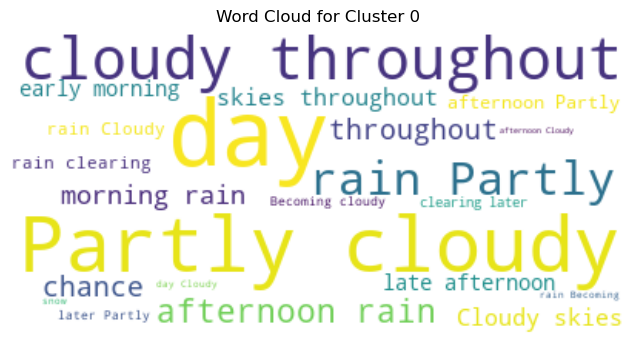

In [52]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==0]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 0')
plt.show()

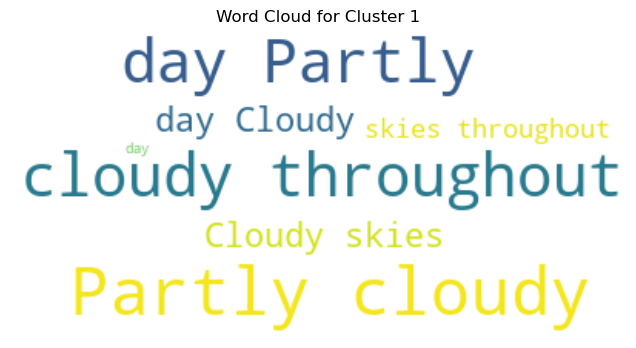

In [53]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==1]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 1')
plt.show()

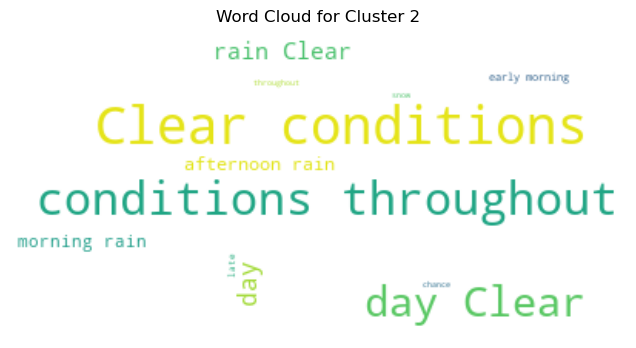

In [54]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==2]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 2')
plt.show()

In [55]:
df_london = df_london.drop(columns=['description'])
df_london.head(2)

temp  dew  humidity  precip  precipprob  precipcover  snow  \
datetime                                                                 
2014-01-01   9.1  6.7      84.8  11.857         100        16.67   0.0   
2014-01-02   9.1  6.0      81.0   5.394         100        12.50   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
datetime                                                                
2014-01-01        0.0      72.4       38.4    190.5             993.1   
2014-01-02        0.0      51.8       29.8    216.2             993.4   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
datetime                                                                   
2014-01-01        67.4        14.2             6.9          0.5        0   
2014-01-02        47.4        26.7            38.3          3.3        2   

            severerisk  moonphase  month  clusters_description  
datetime                                                        
2014-01-01        10.0       0.00      1                     0  
2014-01-02        10.0       0.03      1                     0

## Feature engineering

In [56]:
df_london

temp   dew  humidity  precip  precipprob  precipcover  snow  \
datetime                                                                  
2014-01-01   9.1   6.7      84.8  11.857         100        16.67   0.0   
2014-01-02   9.1   6.0      81.0   5.394         100        12.50   0.0   
2014-01-03   9.0   5.1      76.8   6.030         100        16.67   0.0   
2014-01-04   8.0   5.2      82.4   5.239         100        16.67   0.0   
2014-01-05   6.0   3.9      85.9   0.201         100         8.33   0.0   
...          ...   ...       ...     ...         ...          ...   ...   
2024-05-16  14.2  12.4      89.1  10.126         100        20.83   0.0   
2024-05-17  16.4  10.3      70.2   0.000           0         0.00   0.0   
2024-05-18  15.8  11.7      77.5   2.000         100        25.00   0.0   
2024-05-19  16.6   9.3      63.9   0.000           0         0.00   0.0   
2024-05-20  15.1   9.2      69.8   0.100         100         4.17   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
datetime                                                                
2014-01-01        0.0      72.4       38.4    190.5             993.1   
2014-01-02        0.0      51.8       29.8    216.2             993.4   
2014-01-03        0.0      77.4       33.5    218.4             994.5   
2014-01-04        0.0      62.1       29.2    206.0             993.6   
2014-01-05        0.0      55.6       30.4    192.5            1000.0   
...               ...       ...        ...      ...               ...   
2024-05-16        0.0      18.4       10.1    213.9            1005.2   
2024-05-17        0.0      17.4        9.4    194.8            1009.3   
2024-05-18        0.0      22.7       13.4      5.8            1012.8   
2024-05-19        0.0      34.2       20.3     38.3            1013.8   
2024-05-20        0.0      32.0       19.5     43.4            1013.6   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
datetime                                                                   
2014-01-01        67.4        14.2             6.9          0.5        0   
2014-01-02        47.4        26.7            38.3          3.3        2   
2014-01-03        52.8        17.9            30.3          2.8        2   
2014-01-04        67.6        22.0            17.4          1.4        1   
2014-01-05        66.5        25.5            30.4          2.6        2   
...                ...         ...             ...          ...      ...   
2024-05-16        58.3        15.8            74.5          6.5        3   
2024-05-17        41.4        21.7           177.8         15.5       10   
2024-05-18        83.7         9.7            76.1          6.7        3   
2024-05-19        53.5        10.0           225.0         19.3        9   
2024-05-20        36.8        10.0           217.3         18.7        8   

            severerisk  moonphase  month  clusters_description  
datetime                                                        
2014-01-01        10.0       0.00      1                     0  
2014-01-02        10.0       0.03      1                     0  
2014-01-03        10.0       0.07      1                     0  
2014-01-04        10.0       0.10      1                     0  
2014-01-05        10.0       0.14      1                     0  
...                ...        ...    ...                   ...  
2024-05-16        10.0       0.27      5                     0  
2024-05-17        10.0       0.30      5                     1  
2024-05-18        10.0       0.33      5                     0  
2024-05-19        10.0       0.37      5                     1  
2024-05-20        10.0       0.40      5                     0  

[3793 rows x 21 columns]

In [57]:
# xgboost baseline with all features 
# xgboost with feature selection 
# sktime just for temperature prediction with no features
# sktime lagged features 

## Xgboost baseline with all features 
### Lagged features

In [58]:
#shifting the features by 3 days

In [59]:
# this shifts all features by three days except the temp, and then it merges them back togther
df_london_shifted = df_london.drop('temp', axis=1).shift(3)

In [60]:
df_london_eng = pd.concat([df_london['temp'], df_london_shifted], axis=1)

In [61]:
df_london_eng

temp   dew  humidity  precip  precipprob  precipcover  snow  \
datetime                                                                  
2014-01-01   9.1   NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-02   9.1   NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-03   9.0   NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-04   8.0   6.7      84.8  11.857       100.0        16.67   0.0   
2014-01-05   6.0   6.0      81.0   5.394       100.0        12.50   0.0   
...          ...   ...       ...     ...         ...          ...   ...   
2024-05-16  14.2  11.0      73.4   0.000         0.0         0.00   0.0   
2024-05-17  16.4  11.7      77.8   3.598       100.0        33.33   0.0   
2024-05-18  15.8  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
datetime                                                                
2014-01-01        NaN       NaN        NaN      NaN               NaN   
2014-01-02        NaN       NaN        NaN      NaN               NaN   
2014-01-03        NaN       NaN        NaN      NaN               NaN   
2014-01-04        0.0      72.4       38.4    190.5             993.1   
2014-01-05        0.0      51.8       29.8    216.2             993.4   
...               ...       ...        ...      ...               ...   
2024-05-16        0.0      35.2       21.0    183.4            1007.1   
2024-05-17        0.0      30.5       21.0    149.7            1001.1   
2024-05-18        0.0      25.0       15.2    147.1            1004.2   
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
datetime                                                                   
2014-01-01         NaN         NaN             NaN          NaN      NaN   
2014-01-02         NaN         NaN             NaN          NaN      NaN   
2014-01-03         NaN         NaN             NaN          NaN      NaN   
2014-01-04        67.4        14.2             6.9          0.5      0.0   
2014-01-05        47.4        26.7            38.3          3.3      2.0   
...                ...         ...             ...          ...      ...   
2024-05-16        86.1        14.9            71.5          6.2      2.0   
2024-05-17        85.6        15.4            76.1          6.5      4.0   
2024-05-18        52.3        19.4           118.8         10.3      9.0   
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  month  clusters_description  
datetime                                                        
2014-01-01         NaN        NaN    NaN                   NaN  
2014-01-02         NaN        NaN    NaN                   NaN  
2014-01-03         NaN        NaN    NaN                   NaN  
2014-01-04        10.0       0.00    1.0                   0.0  
2014-01-05        10.0       0.03    1.0                   0.0  
...                ...        ...    ...                   ...  
2024-05-16        10.0       0.17    5.0                   1.0  
2024-05-17        10.0       0.20    5.0                   0.0  
2024-05-18        10.0       0.25    5.0                   0.0  
2024-05-19        10.0       0.27    5.0                   0.0  
2024-05-20        10.0       0.30    5.0                   1.0  

[3793 rows x 21 columns]

In [62]:
df_london_shifted

dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
datetime                                                                       
2014-01-01   NaN       NaN     NaN         NaN          NaN   NaN        NaN   
2014-01-02   NaN       NaN     NaN         NaN          NaN   NaN        NaN   
2014-01-03   NaN       NaN     NaN         NaN          NaN   NaN        NaN   
2014-01-04   6.7      84.8  11.857       100.0        16.67   0.0        0.0   
2014-01-05   6.0      81.0   5.394       100.0        12.50   0.0        0.0   
...          ...       ...     ...         ...          ...   ...        ...   
2024-05-16  11.0      73.4   0.000         0.0         0.00   0.0        0.0   
2024-05-17  11.7      77.8   3.598       100.0        33.33   0.0        0.0   
2024-05-18  10.5      69.7   0.797       100.0         8.33   0.0        0.0   
2024-05-19  12.4      89.1  10.126       100.0        20.83   0.0        0.0   
2024-05-20  10.3      70.2   0.000         0.0         0.00   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                 
2014-01-01       NaN        NaN      NaN               NaN         NaN   
2014-01-02       NaN        NaN      NaN               NaN         NaN   
2014-01-03       NaN        NaN      NaN               NaN         NaN   
2014-01-04      72.4       38.4    190.5             993.1        67.4   
2014-01-05      51.8       29.8    216.2             993.4        47.4   
...              ...        ...      ...               ...         ...   
2024-05-16      35.2       21.0    183.4            1007.1        86.1   
2024-05-17      30.5       21.0    149.7            1001.1        85.6   
2024-05-18      25.0       15.2    147.1            1004.2        52.3   
2024-05-19      18.4       10.1    213.9            1005.2        58.3   
2024-05-20      17.4        9.4    194.8            1009.3        41.4   

            visibility  solarradiation  solarenergy  uvindex  severerisk  \
datetime                                                                   
2014-01-01         NaN             NaN          NaN      NaN         NaN   
2014-01-02         NaN             NaN          NaN      NaN         NaN   
2014-01-03         NaN             NaN          NaN      NaN         NaN   
2014-01-04        14.2             6.9          0.5      0.0        10.0   
2014-01-05        26.7            38.3          3.3      2.0        10.0   
...                ...             ...          ...      ...         ...   
2024-05-16        14.9            71.5          6.2      2.0        10.0   
2024-05-17        15.4            76.1          6.5      4.0        10.0   
2024-05-18        19.4           118.8         10.3      9.0        10.0   
2024-05-19        15.8            74.5          6.5      3.0        10.0   
2024-05-20        21.7           177.8         15.5     10.0        10.0   

            moonphase  month  clusters_description  
datetime                                            
2014-01-01        NaN    NaN                   NaN  
2014-01-02        NaN    NaN                   NaN  
2014-01-03        NaN    NaN                   NaN  
2014-01-04       0.00    1.0                   0.0  
2014-01-05       0.03    1.0                   0.0  
...               ...    ...                   ...  
2024-05-16       0.17    5.0                   1.0  
2024-05-17       0.20    5.0                   0.0  
2024-05-18       0.25    5.0                   0.0  
2024-05-19       0.27    5.0                   0.0  
2024-05-20       0.30    5.0                   1.0  

[3793 rows x 20 columns]

In [63]:
# adding back the last three rows, which have all the shifted features but without the temp for them as that is what we predict
last_three = df_london_shifted.tail(3)
last_three.set_index( pd.date_range(start=max(df_london.index)+pd.Timedelta(days=1), periods=3, freq='D'))


dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
2024-05-21  10.5      69.7   0.797       100.0         8.33   0.0        0.0   
2024-05-22  12.4      89.1  10.126       100.0        20.83   0.0        0.0   
2024-05-23  10.3      70.2   0.000         0.0         0.00   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
2024-05-21      25.0       15.2    147.1            1004.2        52.3   
2024-05-22      18.4       10.1    213.9            1005.2        58.3   
2024-05-23      17.4        9.4    194.8            1009.3        41.4   

            visibility  solarradiation  solarenergy  uvindex  severerisk  \
2024-05-21        19.4           118.8         10.3      9.0        10.0   
2024-05-22        15.8            74.5          6.5      3.0        10.0   
2024-05-23        21.7           177.8         15.5     10.0        10.0   

            moonphase  month  clusters_description  
2024-05-21       0.25    5.0                   0.0  
2024-05-22       0.27    5.0                   0.0  
2024-05-23       0.30    5.0                   1.0

In [64]:
max(df_london.index)+pd.Timedelta(days=1)

Timestamp('2024-05-21 00:00:00')

In [65]:
df_london_final = pd.concat([df_london_eng, last_three], ignore_index=True)

In [66]:
df_london_final = df_london_final.set_index(pd.date_range(start=min(df_london.index), periods=len(df_london)+3, freq='D'))

In [67]:
df_london_final.tail()

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   
2024-05-21   NaN  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-22   NaN  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-23   NaN  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   
2024-05-21        0.0      25.0       15.2    147.1            1004.2   
2024-05-22        0.0      18.4       10.1    213.9            1005.2   
2024-05-23        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   
2024-05-21        52.3        19.4           118.8         10.3      9.0   
2024-05-22        58.3        15.8            74.5          6.5      3.0   
2024-05-23        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  month  clusters_description  
2024-05-19        10.0       0.27    5.0                   0.0  
2024-05-20        10.0       0.30    5.0                   1.0  
2024-05-21        10.0       0.25    5.0                   0.0  
2024-05-22        10.0       0.27    5.0                   0.0  
2024-05-23        10.0       0.30    5.0                   1.0

In [68]:
# we've created three new dates with all the lagged features aside from temp, which will be predicted in the next section

## train and test split based on the date as it's a time series

In [69]:
# because XGBoost is not a time series model (address it as a limitation), i will split the datetime column into days, months and year, so the model can learn which temperature is related to the May month and which temperature is related to the December month, as it learns accross multiple years

In [70]:
df_london_final['month'] = df_london_final.index.month
df_london_final['year'] = df_london_final.index.year

In [71]:
df_dummies = pd.get_dummies(df_london_final['month'], prefix='month')

In [72]:
df_london_final = pd.concat([df_london_final, df_dummies], axis=1)
df_london_final.drop(columns=['month'], inplace=True)

In [73]:
df_london_final

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2014-01-01   9.1   NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-02   9.1   NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-03   9.0   NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-04   8.0   6.7      84.8  11.857       100.0        16.67   0.0   
2014-01-05   6.0   6.0      81.0   5.394       100.0        12.50   0.0   
...          ...   ...       ...     ...         ...          ...   ...   
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   
2024-05-21   NaN  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-22   NaN  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-23   NaN  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2014-01-01        NaN       NaN        NaN      NaN               NaN   
2014-01-02        NaN       NaN        NaN      NaN               NaN   
2014-01-03        NaN       NaN        NaN      NaN               NaN   
2014-01-04        0.0      72.4       38.4    190.5             993.1   
2014-01-05        0.0      51.8       29.8    216.2             993.4   
...               ...       ...        ...      ...               ...   
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   
2024-05-21        0.0      25.0       15.2    147.1            1004.2   
2024-05-22        0.0      18.4       10.1    213.9            1005.2   
2024-05-23        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2014-01-01         NaN         NaN             NaN          NaN      NaN   
2014-01-02         NaN         NaN             NaN          NaN      NaN   
2014-01-03         NaN         NaN             NaN          NaN      NaN   
2014-01-04        67.4        14.2             6.9          0.5      0.0   
2014-01-05        47.4        26.7            38.3          3.3      2.0   
...                ...         ...             ...          ...      ...   
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   
2024-05-21        52.3        19.4           118.8         10.3      9.0   
2024-05-22        58.3        15.8            74.5          6.5      3.0   
2024-05-23        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2014-01-01         NaN        NaN                   NaN  2014     True   
2014-01-02         NaN        NaN                   NaN  2014     True   
2014-01-03         NaN        NaN                   NaN  2014     True   
2014-01-04        10.0       0.00                   0.0  2014     True   
2014-01-05        10.0       0.03                   0.0  2014     True   
...                ...        ...                   ...   ...      ...   
2024-05-19        10.0       0.27                   0.0  2024    False   
2024-05-20        10.0       0.30                   1.0  2024    False   
2024-05-21        10.0       0.25                   0.0  2024    False   
2024-05-22        10.0       0.27                   0.0  2024    False   
2024-05-23        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2014-01-01    False    False    False    False    False    False    False   
2014-01-02    False    False    False    False    False    False    False   
2014-01-03    False    False    False    False    False    False    False   
2014-01-04    False    False    False    False    False    False    False   
2014-01-05    False    False    False    False 

In [74]:
df_train = df_london_final.iloc[:-368] #training set - takes the last 368 days
df_test = df_london_final.iloc[-368:-3] #test set - takes the last 368 - the last 3 days for preds
df_future =  df_london_final.iloc[-3:] #future dataframe that contains the predictions that we will generate but right now jas just the features

In [75]:
df_train.tail()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-17  13.7  8.1      69.3   0.000         0.0         0.00   0.0   
2023-05-18  14.6  5.8      60.6   2.989       100.0        20.83   0.0   
2023-05-19  13.7  5.0      59.5   0.000         0.0         0.00   0.0   
2023-05-20  14.3  7.4      66.7   0.000         0.0         0.00   0.0   
2023-05-21  14.4  7.1      61.6   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-17        0.0      21.5       16.0    307.8            1020.7   
2023-05-18        0.0      41.3       22.9    353.1            1019.9   
2023-05-19        0.0      34.2       18.1    329.3            1024.9   
2023-05-20        0.0      20.5       17.7     16.7            1028.2   
2023-05-21        0.0      24.1       16.0     92.8            1028.0   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-17        65.4        18.3           152.2         13.2      8.0   
2023-05-18        57.3        38.2           134.8         11.6      5.0   
2023-05-19        25.6        27.6           203.8         17.7      9.0   
2023-05-20        38.6        23.2           147.4         12.7      7.0   
2023-05-21        52.3        26.6           161.9         13.9      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-17        10.0       0.81                   0.0  2023    False   
2023-05-18        10.0       0.85                   0.0  2023    False   
2023-05-19        10.0       0.88                   0.0  2023    False   
2023-05-20        10.0       0.92                   1.0  2023    False   
2023-05-21        10.0       0.96                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-17    False    False    False     True    False    False    False   
2023-05-18    False    False    False     True    False    False    False   
2023-05-19    False    False    False     True    False    False    False   
2023-05-20    False    False    False     True    False    False    False   
2023-05-21    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12  
2023-05-17    False     False     False     False  
2023-05-18    False     False     False     False  
2023-05-19    False     False     False     False  
2023-05-20    False     False     False     False  
2023-05-21    False     False     False     False

In [76]:
df_test.head()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1  6.9      64.3     0.0         0.0          0.0   0.0   
2023-05-23  14.0  6.1      60.6     0.0         0.0          0.0   0.0   
2023-05-24  15.8  6.7      61.2     0.0         0.0          0.0   0.0   
2023-05-25  15.0  6.7      57.9     0.0         0.0          0.0   0.0   
2023-05-26  14.2  6.9      63.5     0.0         0.0          0.0   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12  
2023-05-22    False     False     False     False  
2023-05-23    False     False     False     False  
2023-05-24    False     False     False     False  
2023-05-25    False     False     False     False  
2023-05-26    False     False     False     False

In [77]:
df_test.tail()

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2024-05-16  14.2  11.0      73.4   0.000         0.0         0.00   0.0   
2024-05-17  16.4  11.7      77.8   3.598       100.0        33.33   0.0   
2024-05-18  15.8  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2024-05-16        0.0      35.2       21.0    183.4            1007.1   
2024-05-17        0.0      30.5       21.0    149.7            1001.1   
2024-05-18        0.0      25.0       15.2    147.1            1004.2   
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2024-05-16        86.1        14.9            71.5          6.2      2.0   
2024-05-17        85.6        15.4            76.1          6.5      4.0   
2024-05-18        52.3        19.4           118.8         10.3      9.0   
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2024-05-16        10.0       0.17                   1.0  2024    False   
2024-05-17        10.0       0.20                   0.0  2024    False   
2024-05-18        10.0       0.25                   0.0  2024    False   
2024-05-19        10.0       0.27                   0.0  2024    False   
2024-05-20        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2024-05-16    False    False    False     True    False    False    False   
2024-05-17    False    False    False     True    False    False    False   
2024-05-18    False    False    False     True    False    False    False   
2024-05-19    False    False    False     True    False    False    False   
2024-05-20    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12  
2024-05-16    False     False     False     False  
2024-05-17    False     False     False     False  
2024-05-18    False     False     False     False  
2024-05-19    False     False     False     False  
2024-05-20    False     False     False     False

In [78]:
df_future

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2024-05-21   NaN  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-22   NaN  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-23   NaN  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2024-05-21        0.0      25.0       15.2    147.1            1004.2   
2024-05-22        0.0      18.4       10.1    213.9            1005.2   
2024-05-23        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2024-05-21        52.3        19.4           118.8         10.3      9.0   
2024-05-22        58.3        15.8            74.5          6.5      3.0   
2024-05-23        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2024-05-21        10.0       0.25                   0.0  2024    False   
2024-05-22        10.0       0.27                   0.0  2024    False   
2024-05-23        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2024-05-21    False    False    False     True    False    False    False   
2024-05-22    False    False    False     True    False    False    False   
2024-05-23    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12  
2024-05-21    False     False     False     False  
2024-05-22    False     False     False     False  
2024-05-23    False     False     False     False

In [79]:
df_train.head()
df_train.dropna(inplace=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_43808\158935078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(inplace=True)


In [80]:
df_train

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2014-01-04   8.0  6.7      84.8  11.857       100.0        16.67   0.0   
2014-01-05   6.0  6.0      81.0   5.394       100.0        12.50   0.0   
2014-01-06  11.6  5.1      76.8   6.030       100.0        16.67   0.0   
2014-01-07  10.7  5.2      82.4   5.239       100.0        16.67   0.0   
2014-01-08   9.6  3.9      85.9   0.201       100.0         8.33   0.0   
...          ...  ...       ...     ...         ...          ...   ...   
2023-05-17  13.7  8.1      69.3   0.000         0.0         0.00   0.0   
2023-05-18  14.6  5.8      60.6   2.989       100.0        20.83   0.0   
2023-05-19  13.7  5.0      59.5   0.000         0.0         0.00   0.0   
2023-05-20  14.3  7.4      66.7   0.000         0.0         0.00   0.0   
2023-05-21  14.4  7.1      61.6   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2014-01-04        0.0      72.4       38.4    190.5             993.1   
2014-01-05        0.0      51.8       29.8    216.2             993.4   
2014-01-06        0.0      77.4       33.5    218.4             994.5   
2014-01-07        0.0      62.1       29.2    206.0             993.6   
2014-01-08        0.0      55.6       30.4    192.5            1000.0   
...               ...       ...        ...      ...               ...   
2023-05-17        0.0      21.5       16.0    307.8            1020.7   
2023-05-18        0.0      41.3       22.9    353.1            1019.9   
2023-05-19        0.0      34.2       18.1    329.3            1024.9   
2023-05-20        0.0      20.5       17.7     16.7            1028.2   
2023-05-21        0.0      24.1       16.0     92.8            1028.0   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2014-01-04        67.4        14.2             6.9          0.5      0.0   
2014-01-05        47.4        26.7            38.3          3.3      2.0   
2014-01-06        52.8        17.9            30.3          2.8      2.0   
2014-01-07        67.6        22.0            17.4          1.4      1.0   
2014-01-08        66.5        25.5            30.4          2.6      2.0   
...                ...         ...             ...          ...      ...   
2023-05-17        65.4        18.3           152.2         13.2      8.0   
2023-05-18        57.3        38.2           134.8         11.6      5.0   
2023-05-19        25.6        27.6           203.8         17.7      9.0   
2023-05-20        38.6        23.2           147.4         12.7      7.0   
2023-05-21        52.3        26.6           161.9         13.9      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2014-01-04        10.0       0.00                   0.0  2014     True   
2014-01-05        10.0       0.03                   0.0  2014     True   
2014-01-06        10.0       0.07                   0.0  2014     True   
2014-01-07        10.0       0.10                   0.0  2014     True   
2014-01-08        10.0       0.14                   0.0  2014     True   
...                ...        ...                   ...   ...      ...   
2023-05-17        10.0       0.81                   0.0  2023    False   
2023-05-18        10.0       0.85                   0.0  2023    False   
2023-05-19        10.0       0.88                   0.0  2023    False   
2023-05-20        10.0       0.92                   1.0  2023    False   
2023-05-21        10.0       0.96                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2014-01-04    False    False    False    False    False    False    False   
2014-01-05    False    False    False    False    False    False    False   
2014-01-06    False    False    False    False    False    False    False   
2014-01-07    False    False    False    False    False    False    False   
2014-01-08    False    False    False    False    False    

In [81]:
df_test

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1   6.9      64.3   0.000         0.0         0.00   0.0   
2023-05-23  14.0   6.1      60.6   0.000         0.0         0.00   0.0   
2023-05-24  15.8   6.7      61.2   0.000         0.0         0.00   0.0   
2023-05-25  15.0   6.7      57.9   0.000         0.0         0.00   0.0   
2023-05-26  14.2   6.9      63.5   0.000         0.0         0.00   0.0   
...          ...   ...       ...     ...         ...          ...   ...   
2024-05-16  14.2  11.0      73.4   0.000         0.0         0.00   0.0   
2024-05-17  16.4  11.7      77.8   3.598       100.0        33.33   0.0   
2024-05-18  15.8  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   
...               ...       ...        ...      ...               ...   
2024-05-16        0.0      35.2       21.0    183.4            1007.1   
2024-05-17        0.0      30.5       21.0    149.7            1001.1   
2024-05-18        0.0      25.0       15.2    147.1            1004.2   
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   
...                ...         ...             ...          ...      ...   
2024-05-16        86.1        14.9            71.5          6.2      2.0   
2024-05-17        85.6        15.4            76.1          6.5      4.0   
2024-05-18        52.3        19.4           118.8         10.3      9.0   
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   
...                ...        ...                   ...   ...      ...   
2024-05-16        10.0       0.17                   1.0  2024    False   
2024-05-17        10.0       0.20                   0.0  2024    False   
2024-05-18        10.0       0.25                   0.0  2024    False   
2024-05-19        10.0       0.27                   0.0  2024    False   
2024-05-20        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True 

In [82]:
# apply regressor 
# create the predictions 
# look R2 and other performance metrics, add in MAE

In [83]:
df_train

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2014-01-04   8.0  6.7      84.8  11.857       100.0        16.67   0.0   
2014-01-05   6.0  6.0      81.0   5.394       100.0        12.50   0.0   
2014-01-06  11.6  5.1      76.8   6.030       100.0        16.67   0.0   
2014-01-07  10.7  5.2      82.4   5.239       100.0        16.67   0.0   
2014-01-08   9.6  3.9      85.9   0.201       100.0         8.33   0.0   
...          ...  ...       ...     ...         ...          ...   ...   
2023-05-17  13.7  8.1      69.3   0.000         0.0         0.00   0.0   
2023-05-18  14.6  5.8      60.6   2.989       100.0        20.83   0.0   
2023-05-19  13.7  5.0      59.5   0.000         0.0         0.00   0.0   
2023-05-20  14.3  7.4      66.7   0.000         0.0         0.00   0.0   
2023-05-21  14.4  7.1      61.6   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2014-01-04        0.0      72.4       38.4    190.5             993.1   
2014-01-05        0.0      51.8       29.8    216.2             993.4   
2014-01-06        0.0      77.4       33.5    218.4             994.5   
2014-01-07        0.0      62.1       29.2    206.0             993.6   
2014-01-08        0.0      55.6       30.4    192.5            1000.0   
...               ...       ...        ...      ...               ...   
2023-05-17        0.0      21.5       16.0    307.8            1020.7   
2023-05-18        0.0      41.3       22.9    353.1            1019.9   
2023-05-19        0.0      34.2       18.1    329.3            1024.9   
2023-05-20        0.0      20.5       17.7     16.7            1028.2   
2023-05-21        0.0      24.1       16.0     92.8            1028.0   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2014-01-04        67.4        14.2             6.9          0.5      0.0   
2014-01-05        47.4        26.7            38.3          3.3      2.0   
2014-01-06        52.8        17.9            30.3          2.8      2.0   
2014-01-07        67.6        22.0            17.4          1.4      1.0   
2014-01-08        66.5        25.5            30.4          2.6      2.0   
...                ...         ...             ...          ...      ...   
2023-05-17        65.4        18.3           152.2         13.2      8.0   
2023-05-18        57.3        38.2           134.8         11.6      5.0   
2023-05-19        25.6        27.6           203.8         17.7      9.0   
2023-05-20        38.6        23.2           147.4         12.7      7.0   
2023-05-21        52.3        26.6           161.9         13.9      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2014-01-04        10.0       0.00                   0.0  2014     True   
2014-01-05        10.0       0.03                   0.0  2014     True   
2014-01-06        10.0       0.07                   0.0  2014     True   
2014-01-07        10.0       0.10                   0.0  2014     True   
2014-01-08        10.0       0.14                   0.0  2014     True   
...                ...        ...                   ...   ...      ...   
2023-05-17        10.0       0.81                   0.0  2023    False   
2023-05-18        10.0       0.85                   0.0  2023    False   
2023-05-19        10.0       0.88                   0.0  2023    False   
2023-05-20        10.0       0.92                   1.0  2023    False   
2023-05-21        10.0       0.96                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2014-01-04    False    False    False    False    False    False    False   
2014-01-05    False    False    False    False    False    False    False   
2014-01-06    False    False    False    False    False    False    False   
2014-01-07    False    False    False    False    False    False    False   
2014-01-08    False    False    False    False    False    

In [84]:
model_baseline = XGBRegressor()
model_baseline.fit(df_train.drop('temp',axis=1), df_train[['temp']])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [85]:
y_pred_base_xg = model_baseline.predict(df_test.drop('temp',axis=1))

In [86]:
y_pred_base_xg

array([14.492051 , 17.870735 , 16.441523 , 14.017682 , 13.3807955,
       18.364727 , 13.875509 , 16.55626  , 13.40738  , 17.022013 ,
       13.096956 , 15.220464 , 18.718847 , 16.462023 , 17.883986 ,
       18.190876 , 18.983713 , 15.292368 , 13.434772 , 16.804014 ,
       17.765388 , 17.663021 , 17.780577 , 18.162876 , 19.35969  ,
       16.947762 , 18.929035 , 15.666152 , 18.354177 , 16.387234 ,
       18.575077 , 16.272154 , 17.615025 , 20.331121 , 17.903595 ,
       20.021744 , 19.140293 , 18.134293 , 19.111702 , 21.45441  ,
       19.583147 , 20.168015 , 18.224314 , 18.75007  , 18.87896  ,
       17.913774 , 16.178864 , 18.172672 , 20.501274 , 21.236399 ,
       20.726442 , 20.156572 , 17.11704  , 16.378408 , 17.71087  ,
       18.798628 , 16.771502 , 17.329672 , 16.65339  , 17.572655 ,
       19.383886 , 20.404385 , 20.10089  , 18.238998 , 17.524273 ,
       17.880363 , 16.556747 , 16.61994  , 17.54138  , 18.602844 ,
       16.800179 , 17.26145  , 17.58127  , 16.794807 , 18.3065

In [87]:
has_na = np.isnan(y_pred_base_xg).any()
print({has_na})

{False}


In [88]:
na_count = np.isnan(y_pred_base_xg).sum()
print({na_count})

{0}


In [89]:
df_test.isna()

temp    dew  humidity  precip  precipprob  precipcover   snow  \
2023-05-22  False  False     False   False       False        False  False   
2023-05-23  False  False     False   False       False        False  False   
2023-05-24  False  False     False   False       False        False  False   
2023-05-25  False  False     False   False       False        False  False   
2023-05-26  False  False     False   False       False        False  False   
...           ...    ...       ...     ...         ...          ...    ...   
2024-05-16  False  False     False   False       False        False  False   
2024-05-17  False  False     False   False       False        False  False   
2024-05-18  False  False     False   False       False        False  False   
2024-05-19  False  False     False   False       False        False  False   
2024-05-20  False  False     False   False       False        False  False   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22      False     False      False    False             False   
2023-05-23      False     False      False    False             False   
2023-05-24      False     False      False    False             False   
2023-05-25      False     False      False    False             False   
2023-05-26      False     False      False    False             False   
...               ...       ...        ...      ...               ...   
2024-05-16      False     False      False    False             False   
2024-05-17      False     False      False    False             False   
2024-05-18      False     False      False    False             False   
2024-05-19      False     False      False    False             False   
2024-05-20      False     False      False    False             False   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22       False       False           False        False    False   
2023-05-23       False       False           False        False    False   
2023-05-24       False       False           False        False    False   
2023-05-25       False       False           False        False    False   
2023-05-26       False       False           False        False    False   
...                ...         ...             ...          ...      ...   
2024-05-16       False       False           False        False    False   
2024-05-17       False       False           False        False    False   
2024-05-18       False       False           False        False    False   
2024-05-19       False       False           False        False    False   
2024-05-20       False       False           False        False    False   

            severerisk  moonphase  clusters_description   year  month_1  \
2023-05-22       False      False                 False  False    False   
2023-05-23       False      False                 False  False    False   
2023-05-24       False      False                 False  False    False   
2023-05-25       False      False                 False  False    False   
2023-05-26       False      False                 False  False    False   
...                ...        ...                   ...    ...      ...   
2024-05-16       False      False                 False  False    False   
2024-05-17       False      False                 False  False    False   
2024-05-18       False      False                 False  False    False   
2024-05-19       False      False                 False  False    False   
2024-05-20       False      False                 False  False    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False    False    False    False    False   
2023-05-23    False    False    False    False    False    False    False   
2023-05-24    False    False    False    False    False    False    False   
2023-05-25    False    False    False    False    False    False    False   


In [90]:
#performance metrics
#df_test has na 

In [91]:
mae = mean_absolute_error(df_test['temp'], y_pred_base_xg)
mse = mean_squared_error(df_test['temp'], y_pred_base_xg)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], y_pred_base_xg)

print(f"Mean Absolute Error (MAE) for XGBoost baseline with all regressors: {mae}")
print(f"Mean Squared Error (MSE) for XGBoost baseline with all regressors: {mse}")
print(f"Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: {rmse}")
print(f"R-squared (R2) for XGBoost baseline with all regressors: {r2}")

Mean Absolute Error (MAE) for XGBoost baseline with all regressors: 2.3868065674664227
Mean Squared Error (MSE) for XGBoost baseline with all regressors: 8.827414221743139
Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: 2.971096467929498
R-squared (R2) for XGBoost baseline with all regressors: 0.6797312280993014


In [92]:
# for RMSE: if my prediction is errored I want that to inflate the error - but don't know in which direction
# MAE: it means it's 2.3 degrees away from truth just don't know in which direction 

## Predictions vs Actuals

In [93]:
df_test[['temp']]

temp
2023-05-22  15.1
2023-05-23  14.0
2023-05-24  15.8
2023-05-25  15.0
2023-05-26  14.2
...          ...
2024-05-16  14.2
2024-05-17  16.4
2024-05-18  15.8
2024-05-19  16.6
2024-05-20  15.1

[365 rows x 1 columns]

In [94]:
df_test_w_preds = df_test.copy()

In [95]:
#create new column in order to attach index date to the preds
df_test_w_preds['preds'] = y_pred_base_xg

In [96]:
def plot_forecast(actuals, predictions): 
    plt.figure(figsize=(15, 10))
    plt.plot(actuals, label='Actuals', marker='o')
    plt.plot(predictions, label='Preds', marker='s')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title('Predicted vs Actual temperature for XGBoost baseline model with all features')
    plt.show()

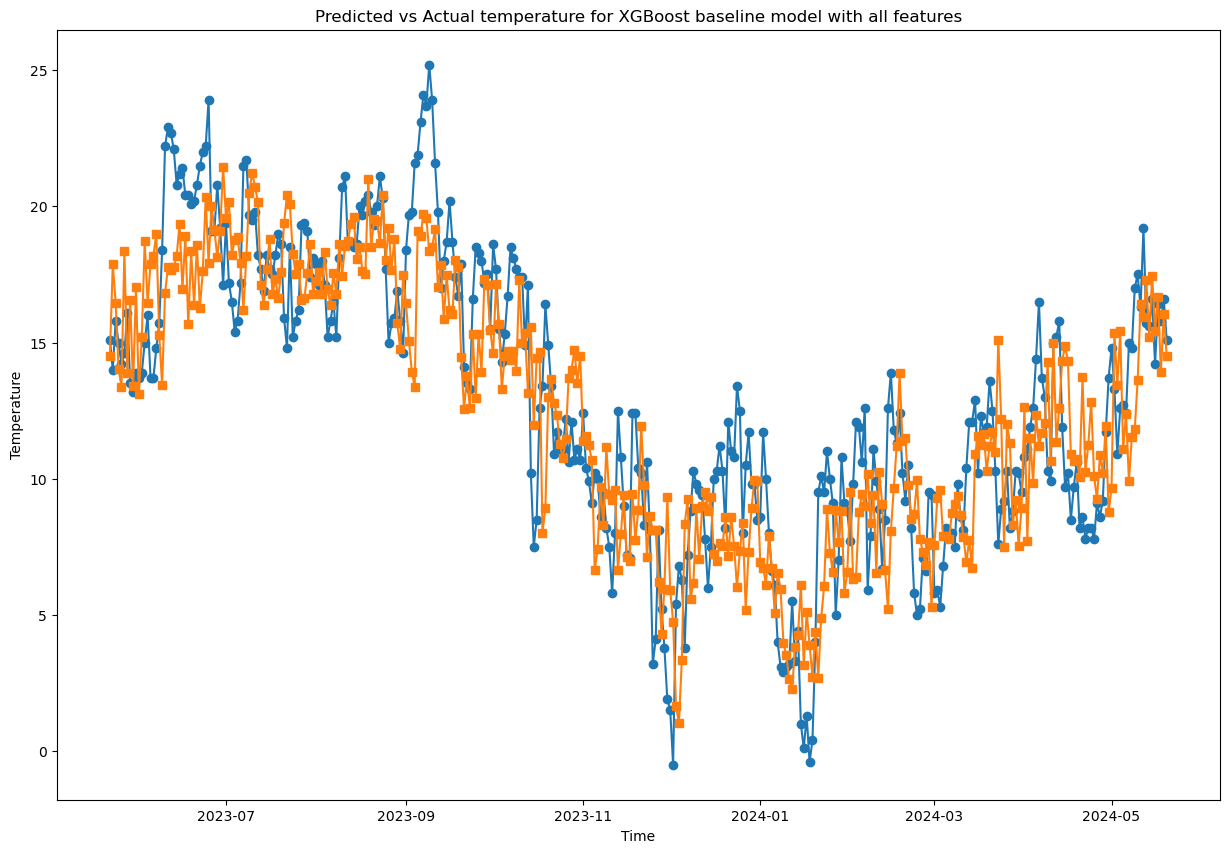

In [97]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds']])

## Feature importance

In [98]:
from xgboost import plot_importance

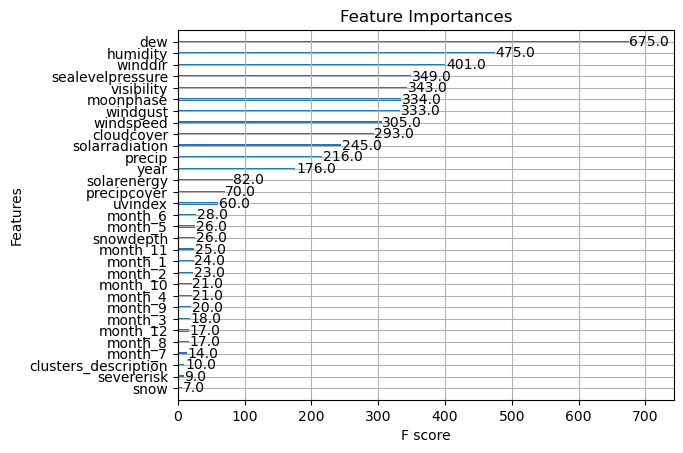

In [99]:
plot_importance(model_baseline)
plt.title('Feature Importances')
plt.show()

In [100]:
# look into dew and the importance of it in terms of climate change and weather prediction 
# the year has quite an important impact as it shows that the average temp is changing every year and therefore has an impact on all predictions
# it proves the temperature changes every year, and it is not cyclical 
# try removing all below 30 

In [101]:
future_preds = model_baseline.predict(df_future.drop('temp', axis=1))

In [102]:
df_future['preds'] = future_preds

C:\Users\nicol\AppData\Local\Temp\ipykernel_43808\2036312194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_future['preds'] = future_preds


In [103]:
df_future

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2024-05-21   NaN  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-22   NaN  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-23   NaN  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2024-05-21        0.0      25.0       15.2    147.1            1004.2   
2024-05-22        0.0      18.4       10.1    213.9            1005.2   
2024-05-23        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2024-05-21        52.3        19.4           118.8         10.3      9.0   
2024-05-22        58.3        15.8            74.5          6.5      3.0   
2024-05-23        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2024-05-21        10.0       0.25                   0.0  2024    False   
2024-05-22        10.0       0.27                   0.0  2024    False   
2024-05-23        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2024-05-21    False    False    False     True    False    False    False   
2024-05-22    False    False    False     True    False    False    False   
2024-05-23    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12      preds  
2024-05-21    False     False     False     False  13.906611  
2024-05-22    False     False     False     False  16.043221  
2024-05-23    False     False     False     False  14.519270

## Grid search model hyperparameter tuning XGBOOST 

In [104]:
df_train

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2014-01-04   8.0  6.7      84.8  11.857       100.0        16.67   0.0   
2014-01-05   6.0  6.0      81.0   5.394       100.0        12.50   0.0   
2014-01-06  11.6  5.1      76.8   6.030       100.0        16.67   0.0   
2014-01-07  10.7  5.2      82.4   5.239       100.0        16.67   0.0   
2014-01-08   9.6  3.9      85.9   0.201       100.0         8.33   0.0   
...          ...  ...       ...     ...         ...          ...   ...   
2023-05-17  13.7  8.1      69.3   0.000         0.0         0.00   0.0   
2023-05-18  14.6  5.8      60.6   2.989       100.0        20.83   0.0   
2023-05-19  13.7  5.0      59.5   0.000         0.0         0.00   0.0   
2023-05-20  14.3  7.4      66.7   0.000         0.0         0.00   0.0   
2023-05-21  14.4  7.1      61.6   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2014-01-04        0.0      72.4       38.4    190.5             993.1   
2014-01-05        0.0      51.8       29.8    216.2             993.4   
2014-01-06        0.0      77.4       33.5    218.4             994.5   
2014-01-07        0.0      62.1       29.2    206.0             993.6   
2014-01-08        0.0      55.6       30.4    192.5            1000.0   
...               ...       ...        ...      ...               ...   
2023-05-17        0.0      21.5       16.0    307.8            1020.7   
2023-05-18        0.0      41.3       22.9    353.1            1019.9   
2023-05-19        0.0      34.2       18.1    329.3            1024.9   
2023-05-20        0.0      20.5       17.7     16.7            1028.2   
2023-05-21        0.0      24.1       16.0     92.8            1028.0   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2014-01-04        67.4        14.2             6.9          0.5      0.0   
2014-01-05        47.4        26.7            38.3          3.3      2.0   
2014-01-06        52.8        17.9            30.3          2.8      2.0   
2014-01-07        67.6        22.0            17.4          1.4      1.0   
2014-01-08        66.5        25.5            30.4          2.6      2.0   
...                ...         ...             ...          ...      ...   
2023-05-17        65.4        18.3           152.2         13.2      8.0   
2023-05-18        57.3        38.2           134.8         11.6      5.0   
2023-05-19        25.6        27.6           203.8         17.7      9.0   
2023-05-20        38.6        23.2           147.4         12.7      7.0   
2023-05-21        52.3        26.6           161.9         13.9      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2014-01-04        10.0       0.00                   0.0  2014     True   
2014-01-05        10.0       0.03                   0.0  2014     True   
2014-01-06        10.0       0.07                   0.0  2014     True   
2014-01-07        10.0       0.10                   0.0  2014     True   
2014-01-08        10.0       0.14                   0.0  2014     True   
...                ...        ...                   ...   ...      ...   
2023-05-17        10.0       0.81                   0.0  2023    False   
2023-05-18        10.0       0.85                   0.0  2023    False   
2023-05-19        10.0       0.88                   0.0  2023    False   
2023-05-20        10.0       0.92                   1.0  2023    False   
2023-05-21        10.0       0.96                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2014-01-04    False    False    False    False    False    False    False   
2014-01-05    False    False    False    False    False    False    False   
2014-01-06    False    False    False    False    False    False    False   
2014-01-07    False    False    False    False    False    False    False   
2014-01-08    False    False    False    False    False    

In [105]:
from sklearn.model_selection import GridSearchCV

In [106]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'max_leaf_nodes':  [0, 10, 20], 
    'reg_lambda': [0, 0.1, 1]
}

grid_search = GridSearchCV(estimator=model_baseline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [107]:
grid_search.fit(df_train.drop('temp', axis=1), df_train['temp']) #first one is train without target, second one is just target

best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\nicol\anaconda3\envs\AI2023\lib\site-packages\xgboost\core.py:160: UserWarning: [11:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)


In [108]:
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 0, 'reg_lambda': 1, 'subsample': 0.7}
Best score: -7.226425704507559


In [109]:
gs_model = XGBRegressor(learning_rate= 0.1, max_depth= 3, subsample= 0.7, max_leaf_nodes=0, reg_lambda=1)
gs_model.fit(df_train.drop('temp',axis=1), df_train[['temp']])

C:\Users\nicol\anaconda3\envs\AI2023\lib\site-packages\xgboost\core.py:160: UserWarning: [11:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaf_nodes=0,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [110]:
pred_gs_model = gs_model.predict(df_test.drop('temp',axis=1))

## Performance metrics for gs model xgsboot

In [111]:
mae = mean_absolute_error(df_test['temp'], pred_gs_model)
mse = mean_squared_error(df_test['temp'], pred_gs_model)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], pred_gs_model)

print(f"Mean Absolute Error (MAE) for GS model: {mae}")
print(f"Mean Squared Error (MSE) for GS model: {mse}")
print(f"Root Mean Squared Error (RMSE) for GS model: {rmse}")
print(f"R-squared (R2) for XGBoost baseline GS model: {r2}")

Mean Absolute Error (MAE) for GS model: 2.1030320937012976
Mean Squared Error (MSE) for GS model: 7.130397327265726
Root Mean Squared Error (RMSE) for GS model: 2.6702803836424605
R-squared (R2) for XGBoost baseline GS model: 0.7413009588309011


In [112]:
df_test_w_preds['preds_gs'] = pred_gs_model

In [113]:
def plot_forecast(actuals, predictions): 
    plt.plot(actuals, label='Actuals', marker='o')
    plt.plot(predictions, label='Preds', marker='s')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title('Predicted vs Actual temperature for XGBoost grid search model')
    plt.show()

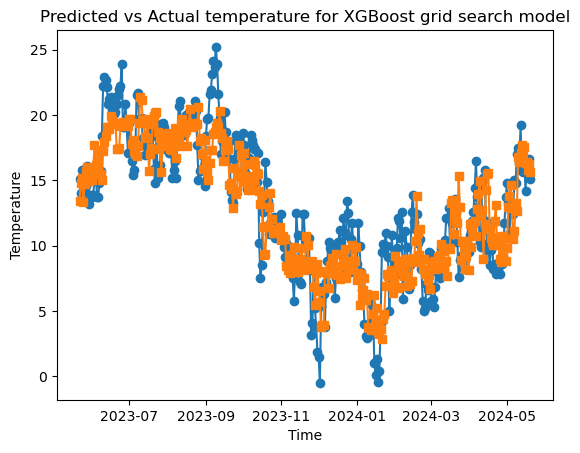

In [114]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds_gs']]) #rememer to not define the function again, just add in the new title when you call the function

## SKtime baseline model - very basic prediction model for comparative study

In [115]:
from sktime.forecasting.naive import NaiveForecaster

https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html

In [116]:
forecaster_baseline = NaiveForecaster(strategy="mean")
forecaster_baseline.fit(df_train['temp'])

NaiveForecaster(strategy='mean')

In [117]:
preds_naive_baseline = forecaster_baseline.predict(df_test.index)

In [118]:
preds_naive_baseline

2023-05-22    12.189839
2023-05-23    12.189839
2023-05-24    12.189839
2023-05-25    12.189839
2023-05-26    12.189839
                ...    
2024-05-16    12.189839
2024-05-17    12.189839
2024-05-18    12.189839
2024-05-19    12.189839
2024-05-20    12.189839
Freq: D, Name: temp, Length: 365, dtype: float64

In [119]:
df_test_w_preds['sktime_naive'] = preds_naive_baseline

In [120]:
df_test_w_preds

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1   6.9      64.3   0.000         0.0         0.00   0.0   
2023-05-23  14.0   6.1      60.6   0.000         0.0         0.00   0.0   
2023-05-24  15.8   6.7      61.2   0.000         0.0         0.00   0.0   
2023-05-25  15.0   6.7      57.9   0.000         0.0         0.00   0.0   
2023-05-26  14.2   6.9      63.5   0.000         0.0         0.00   0.0   
...          ...   ...       ...     ...         ...          ...   ...   
2024-05-16  14.2  11.0      73.4   0.000         0.0         0.00   0.0   
2024-05-17  16.4  11.7      77.8   3.598       100.0        33.33   0.0   
2024-05-18  15.8  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   
...               ...       ...        ...      ...               ...   
2024-05-16        0.0      35.2       21.0    183.4            1007.1   
2024-05-17        0.0      30.5       21.0    149.7            1001.1   
2024-05-18        0.0      25.0       15.2    147.1            1004.2   
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   
...                ...         ...             ...          ...      ...   
2024-05-16        86.1        14.9            71.5          6.2      2.0   
2024-05-17        85.6        15.4            76.1          6.5      4.0   
2024-05-18        52.3        19.4           118.8         10.3      9.0   
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   
...                ...        ...                   ...   ...      ...   
2024-05-16        10.0       0.17                   1.0  2024    False   
2024-05-17        10.0       0.20                   0.0  2024    False   
2024-05-18        10.0       0.25                   0.0  2024    False   
2024-05-19        10.0       0.27                   0.0  2024    False   
2024-05-20        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True 

## AUTO ARIMA

In [121]:
from sktime.forecasting.arima import AutoARIMA

In [122]:
df_train_short = df_train[df_train.index > pd.to_datetime('2021-01-01')]

In [123]:
forecaster_arima = AutoARIMA(sp=12, suppress_warnings=True)
forecaster_arima.fit(df_train_short['temp'])

AutoARIMA(sp=12, suppress_warnings=True)

In [124]:
preds_autoarima = forecaster_arima.predict(df_test.index)

In [125]:
preds_autoarima

2023-05-22    13.984044
2023-05-23    13.895126
2023-05-24    13.759057
2023-05-25    13.725513
2023-05-26    13.632718
                ...    
2024-05-16    13.488740
2024-05-17    13.489218
2024-05-18    13.488746
2024-05-19    13.489213
2024-05-20    13.488752
Freq: D, Name: temp, Length: 365, dtype: float64

In [126]:
df_test_w_preds['preds_autoarima'] = preds_autoarima
df_test_w_preds

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1   6.9      64.3   0.000         0.0         0.00   0.0   
2023-05-23  14.0   6.1      60.6   0.000         0.0         0.00   0.0   
2023-05-24  15.8   6.7      61.2   0.000         0.0         0.00   0.0   
2023-05-25  15.0   6.7      57.9   0.000         0.0         0.00   0.0   
2023-05-26  14.2   6.9      63.5   0.000         0.0         0.00   0.0   
...          ...   ...       ...     ...         ...          ...   ...   
2024-05-16  14.2  11.0      73.4   0.000         0.0         0.00   0.0   
2024-05-17  16.4  11.7      77.8   3.598       100.0        33.33   0.0   
2024-05-18  15.8  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   
...               ...       ...        ...      ...               ...   
2024-05-16        0.0      35.2       21.0    183.4            1007.1   
2024-05-17        0.0      30.5       21.0    149.7            1001.1   
2024-05-18        0.0      25.0       15.2    147.1            1004.2   
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   
...                ...         ...             ...          ...      ...   
2024-05-16        86.1        14.9            71.5          6.2      2.0   
2024-05-17        85.6        15.4            76.1          6.5      4.0   
2024-05-18        52.3        19.4           118.8         10.3      9.0   
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   
...                ...        ...                   ...   ...      ...   
2024-05-16        10.0       0.17                   1.0  2024    False   
2024-05-17        10.0       0.20                   0.0  2024    False   
2024-05-18        10.0       0.25                   0.0  2024    False   
2024-05-19        10.0       0.27                   0.0  2024    False   
2024-05-20        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True 

## SARIMAX FROM SKTIME - with all features

In [127]:
from sktime.forecasting.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_london['temp'], lags=40, ax=ax[0])
plot_pacf(df_london['temp'], lags=40, ax=ax[1])
plt.show()

In [ ]:
forecaster_sarimax = SARIMAX(order=(2, 0, 1), trend="t", seasonal_order=(1, 0, 0, 365))
forecaster_sarimax.fit(df_train) 

In [142]:
from statsmodels.tsa.statespace.sarimax import SARIMAX as StatsmodelsSARIMAX

In [ ]:
df_train_short.drop('temp',axis=1).astype(float)

In [ ]:
model_sarimax_baseline = StatsmodelsSARIMAX(
    endog=df_train_short['temp'],
    exog=df_train_short.drop('temp',axis=1).astype(float),
    order=(1, 1, 1),  
    seasonal_order=(1, 1, 1, 12)  
)

In [ ]:
sarimax_base_results = model_sarimax_baseline.fit()

In [ ]:
forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))

In [ ]:
forecast_sarimax.predicted_mean

In [ ]:
df_test_w_preds['preds_sarimax'] = forecast_sarimax.predicted_mean
df_test_w_preds

## SARIMAX GS

In [129]:
sarimax_results=df_test_w_preds.copy()

In [138]:
def gridsearch_sarimax(p,d,q,P,D,Q,S,df_results_sarimax): 
    print(p,d,q,P,D,Q,S)
    model_sarimax_baseline = StatsmodelsSARIMAX(
    endog=df_train_short['temp'],
    exog=df_train_short.drop('temp',axis=1).astype(float),
    order=(p,d,q),  
    seasonal_order=(P,D,Q,S))
    sarimax_base_results = model_sarimax_baseline.fit()
    forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))
    df_results_sarimax[f"{p}_{d}_{q}_{P}_{D}_{Q}_{S}"]=forecast_sarimax.predicted_mean
    return df_results_sarimax

In [139]:
p_values = range(0, 2)
d_values = [1]
q_values = range(0, 2)
P_values = range(0, 2)
D_values = [1]
Q_values = range(0, 2)
s_values = [365]

In [ ]:
for p in p_values: 
    for d in d_values:
        for q in q_values: 
            for P in P_values: 
                for D in D_values: 
                    for Q in Q_values: 
                        for s in s_values:
                            sarimax_results = gridsearch_sarimax(p,d,q,P,D,Q,s,sarimax_results)

0 1 0 0 1 0 365


## LSTM baseline

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df_london[['temp']])

In [ ]:
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

def split_sequence(sequence, n_steps):
    xs, ys = [], []
    for i in range(len(sequence) - n_steps):
        x = sequence[i:i + n_steps]
        y = sequence[i + n_steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
from numpy import array
n_steps = 30
X_train, y_train= split_sequence(values, n_steps)
X_test, y_test = split_sequence(values, n_steps)

In [ ]:
#number of steps will be the lagged features of 3

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
y_test #this is the series we're trying to predict, try to create a 3D feature set 

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [ ]:
# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
model_baseline = Sequential()
model_baseline.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
model_baseline.add(LSTM(50))
model_baseline.add(Dense(1))
model_baseline.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_baseline.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
def predict_future(model, data, n_steps, predict_n_days):
    prediction_list = data[-n_steps:].tolist()
    prediction_list = [item[0] for item in prediction_list]
    
    for _ in range(predict_n_days):
        x = np.array(prediction_list[-n_steps:]).reshape((1, n_steps, 1))
        out = model.predict(x)[0][0]
        prediction_list.append(out)

    # Transform the predictions back to the original scale
    prediction_list = scaler.inverse_transform(np.array(prediction_list).reshape(-1, 1))
    return prediction_list

In [ ]:
predict_n_days = 365


In [ ]:
yhat_baseline = predict_future(model_baseline, values, n_steps, predict_n_days)

In [ ]:
yhat_baseline[n_steps:]

In [ ]:
len(yhat_baseline[n_steps:])

In [ ]:
df_test_w_preds['lstm_base'] = yhat_baseline[n_steps:]
df_test_w_preds

In [ ]:
# the model is very weak and it's predicting the same 200+ temperature. it needs improving with additiona layers

### Improved layers - LSTM

In [ ]:
model_lstm_two = Sequential()
model_lstm_two.add(LSTM(100, return_sequences=True, input_shape=(n_steps, 1)))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(LSTM(100, return_sequences=False))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(Dense(50, activation='relu'))

model_lstm_two.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model_lstm_two.compile(optimizer=optimizer, loss='mean_squared_error')

history = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
yhat_lstm_two = predict_future(model_lstm_two, values, n_steps, predict_n_days)

In [ ]:
df_test_w_preds['lstm_two_layers'] = yhat_lstm_two[n_steps:]
df_test_w_preds

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Tuning batch size for LSTM

In [ ]:
history_batchsize_1 = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=1, validation_data=(X_test, y_test))


In [ ]:
yhat_lstm_batch_1 = predict_future(model_lstm_two, values, n_steps, predict_n_days)


In [ ]:
df_test_w_preds['lstm_two_layers_batch_size_1'] = yhat_lstm_batch_1[n_steps:]


In [ ]:
df_test_w_preds

## Download of updated dataframe

In [ ]:
# folder_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data'
# file_name = 'london_weather_2014-2024_updated.csv'
# full_path = os.path.join(folder_path, file_name)

# # save the DataFrame to the specified path
# df_london.to_csv(full_path)